# Kernel Density Estimators

Given observations $X_1,\dots,X_n$ and weights at each observation $W_1,\dots,W_n$, we will illustrate the Kernel Density estimate $\hat{p}(x)$ of the unknown distribution $p(x)$ of the $X_i$. The estimate starts with a smoothing kernel $k(x) \ge 0$, which has area equal to one. In the Calculus of integrals this is stated as
$$
\int k(x) \operatorname{d}x = 1
$$
We then introduce a smoothing parameter $h>0$, that acts like the variance of the kernel. Larger values of $h$ stertch the kernel out, while smaller values sharpen it. The estimator is given as the sum over the translations of the kernel by the observations and multiplied by the weights $W_i > 0$
$$
\hat{p}_h(x) = \frac{W_1 \cdot k\left(\frac{x - X_1}{h}\right) + \cdots + W_n \cdot k\left(\frac{x - X_n}{h} \right)}{h \cdot \left(W_1 + \cdots + W_n\right)}
$$

In [1]:
# The usual suspects.
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as mp
from sklearn.neighbors import KernelDensity as kd
import numpy as np
import ipywidgets as wg

### Kernel Functions

There are many possible choices of Kernel Functions. The three most common are the Gauss, Tophat, and the Triangular. Lets take a look at each of these.

#### Gauss Kernel

This is also called the Normal Curve, or the Bell Curve.

$$
k(x) = \frac{\operatorname{e}^{-\frac{x^2}{2}}}{\sqrt{2\pi}}
$$

#### Tophat Kernel

This is also called the Boxcar or Indicator function.

$$
k(x) =
\begin{cases}
1 & |x| \le \frac{1}{2}
\\
0 & \text{otherwise}
\end{cases}
$$

#### Triangular Kernel

This is also called the Trapeziodal function.

$$
k(x) =
\begin{cases}
1 - |x| & |x| \le 1
\\
0 & \text{otherwise}
\end{cases}
$$

We can plot each one of these along with parameters to adjust the bandwidth $h$, and center $c$, using the sliders.

interactive(children=(FloatSlider(value=0.0, description='c', max=9.0, min=-9.0), FloatSlider(value=1.0, descr…

<function __main__.redraw(c=0, h=1)>

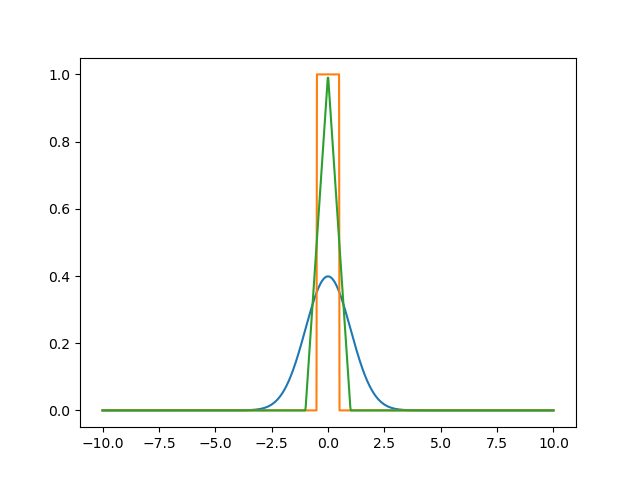

In [2]:
# Gauss unit kernel, operations are natively vectorized
def gauss(x):
    return np.e**(-(x**2)/2) / np.sqrt(2*np.pi)

# Tophat unit kernel, requires vectorization
def _tophat(x):
    if abs(x) > 1/2:
        return 0.
    else:
        return 1.
tophat = np.vectorize(_tophat)

# Triangular unit kernel, requires vectorization
def _triangular(x):
    if abs(x) > 1:
        return 0.
    else:
        return 1. - abs(x)
triangular = np.vectorize(_triangular)

# X-axis ticks
xticks = np.linspace(-10, 10, 1000)

# Blank canvas
kernelfig, kernelaxis = mp.subplots()

# Individual curves
gausscurve, = kernelaxis.plot(xticks, gauss(xticks))
tophatcurve, = kernelaxis.plot(xticks, tophat(xticks))
triangularcurve, = kernelaxis.plot(xticks, triangular(xticks))

# Redraw commands
def redraw(c = 0, h = 1):
    gausscurve.set_ydata(gauss((xticks-c)/h)/h)
    tophatcurve.set_ydata(tophat((xticks-c)/h)/h)
    triangularcurve.set_ydata(triangular((xticks-c)/h)/h)
    kernelfig.canvas.draw_idle()

# Illustrate
wg.interact(redraw, c = (-9, 9, 0.1), h = (0.1, 5, 0.1))

### Data Sources

We are using the Our World in data files:
* `Data/population-and-demography.csv`
* `Data/life-expectancy.csv`
* `Data/national-gdp-penn-world-table.csv`

In [11]:
# Load our data
population = pd.read_csv("Data/population-and-demography.csv")
lifeexpectancy = pd.read_csv("Data/life-expectancy.csv")
gdp = pd.read_csv("Data/national-gdp-penn-world-table.csv")

### View Data

This is important, especially for smaller dataframes. You can view the entire contents of a dataframe in a data view table by selecting the `JUPYTER` viewer in the debug window. Then simple double click on any variable to view it.

As en example we add a couple scalar variables to the global environment.

In [12]:
# Variable declarations in the global context
myname = "Mr. Sheldon"
myage = 50

# Declare another variable in the global context
howoldIwishIwas = 35
thisislist = ["blue", "yellow", "orange", 34, [45, 0.56, "tuna"]]

### Join Our Datasets

Okay great we have data in separate dataframe. I need them all in one frame. To do this we use
Pandas `merge` function
1. We will start by showing how to merge GPD with Life Expectancy because they have the columns `Entity`, `Code`, and `Year` in common.
2. We will do a full `outer` join to ensure all records are included from both, even when mismatched.
3. We will then merge this again with Population.
4. This step requires matching `Country name` to `Entity`, and `Year` to `Year`.

In [13]:
# Step 1 and 2
LEouterGDP = pd.merge(
    left = lifeexpectancy,
    right = gdp,
    how = "outer",
    on = ["Year", "Code", "Entity"]
)

# Step 3 and 4
NationAnnual = pd.merge(
    left = population,
    right = LEouterGDP,
    how = "outer",
    left_on = ["Year", "Country name"],
    right_on = ["Year", "Entity"]
)

### Histograms and Smoothing

Now that we have the data linked together, lets create a histogram of GDP by Life Expectancy, for the year 2010, in a reusable plot. We wil then place the smoothed version over top.

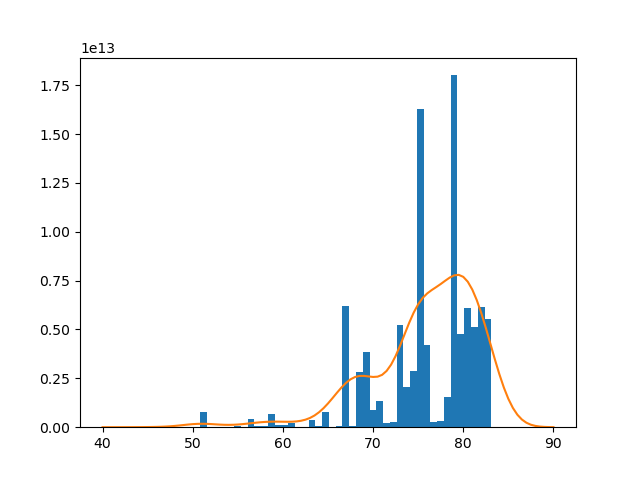

In [15]:
# Blank canvas
fg, ax = mp.subplots()

# We only want to look at one year at a time
year = 2010
Nation2010 = NationAnnual[
    (NationAnnual["Year"] == year) & 
    (pd.notnull(NationAnnual["Code"])) &
    (pd.notnull(NationAnnual["Period life expectancy at birth - Sex: all - Age: 0"])) &
    (pd.notnull(NationAnnual["GDP (output, multiple price benchmarks)"]))
]

# Add a histogram to the canvas
ax.hist(
    x = Nation2010["Period life expectancy at birth - Sex: all - Age: 0"],
    weights = Nation2010["GDP (output, multiple price benchmarks)"],
    bins = 50
)

# First we need to "fit" the smoothed estimate to the data
smoothed2010 = kd(
    kernel = "gaussian",
    bandwidth = 2.
).fit(
    X = Nation2010["Period life expectancy at birth - Sex: all - Age: 0"].values.reshape(-1, 1),
    sample_weight = Nation2010["GDP (output, multiple price benchmarks)"].values
)

# We have a "model" now. Lets evaluate that model at different ages.
ages = np.linspace(40, 90, 101)[:, np.newaxis]

# Evaluate the model at each age that we just created.
estimategdp = np.exp(smoothed2010.score_samples(ages)) * sum(Nation2010["GDP (output, multiple price benchmarks)"])

# Try plotting
ax.plot(
    ages[:, 0],
    estimategdp,
    linestyle = "-"
)